# Немного о самом PCA

Подключим требующиеся для моделирования дальнейшего библиотеки

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt 

Сгенерируем набор данных

In [22]:
x = np.arange(1,11)
np.random.seed(42)
y = 2 * (x + np.random.randn(10))
data = pd.DataFrame({'x': x, 'y': y})

Визуализируем то, что получилось после генерации:

<Axes: xlabel='x', ylabel='y'>

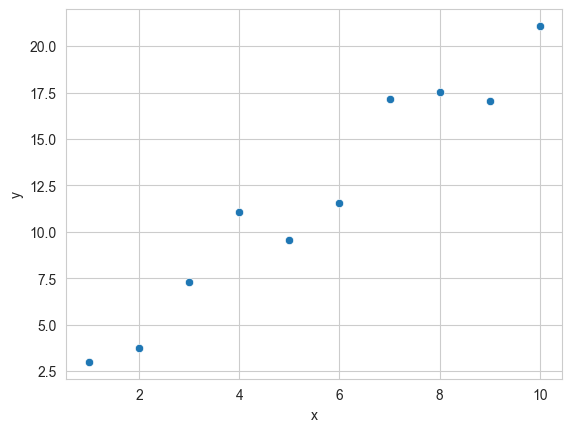

In [17]:
sns.set_style('whitegrid')
sns.scatterplot(data = data, x='x', y='y')

Начнем применять алгоритм PCA. Сначала центрируем наши данные:

In [18]:
centered_data = data - (x.mean(), y.mean())

Посмотрим, что все прошло корректно:

<Axes: xlabel='x', ylabel='y'>

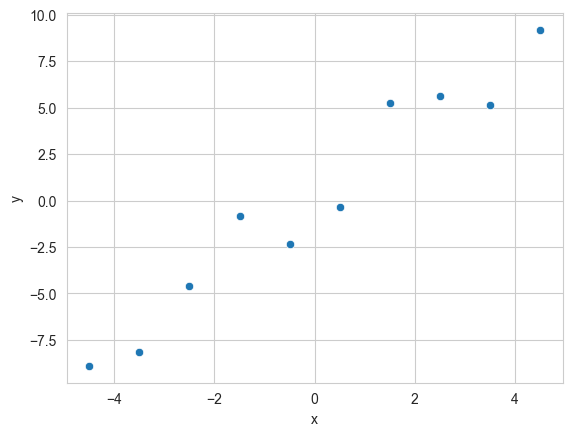

In [19]:
sns.scatterplot(data = centered_data, x='x', y='y')

Вычислим матрицу выборочных ковариаций:

In [23]:
F = np.dot(centered_data.T, centered_data)/(len(centered_data.index))
F

array([[ 8.25      , 16.38614387],
       [16.38614387, 34.42644325]])

Можно воспользоваться и встроенными в `numpy` функциями:

In [24]:
F_numpy = np.cov(centered_data.T)
F_numpy

array([[ 9.16666667, 18.20682652],
       [18.20682652, 38.25160361]])

Видите, как бывает полезно проверить, а что на самом деле делает библиотека. Впрочем, все достаточно очевидно.

In [25]:
F_numpy = np.cov(centered_data.T, ddof=0)
F_numpy

array([[ 8.25      , 16.38614387],
       [16.38614387, 34.42644325]])

Теперь найдем собственные числа и соответсвующие им собственные векторы

In [26]:
eigvalues, eigvectors = np.linalg.eig(F)

print(eigvalues)
print(eigvectors)

[ 0.36663952 42.30980373]
[[-0.90113628 -0.43353593]
 [ 0.43353593 -0.90113628]]


Собственыне числа показывают дисперсии. Значит, среднеквадратические отклонения `sigma` — корни из дисперсии. Увидим, какой разброс «в среднем» гарантирует нам статистика (`axes`):

In [27]:
sigma = eigvalues ** 0.5
axes = eigvectors * sigma.T

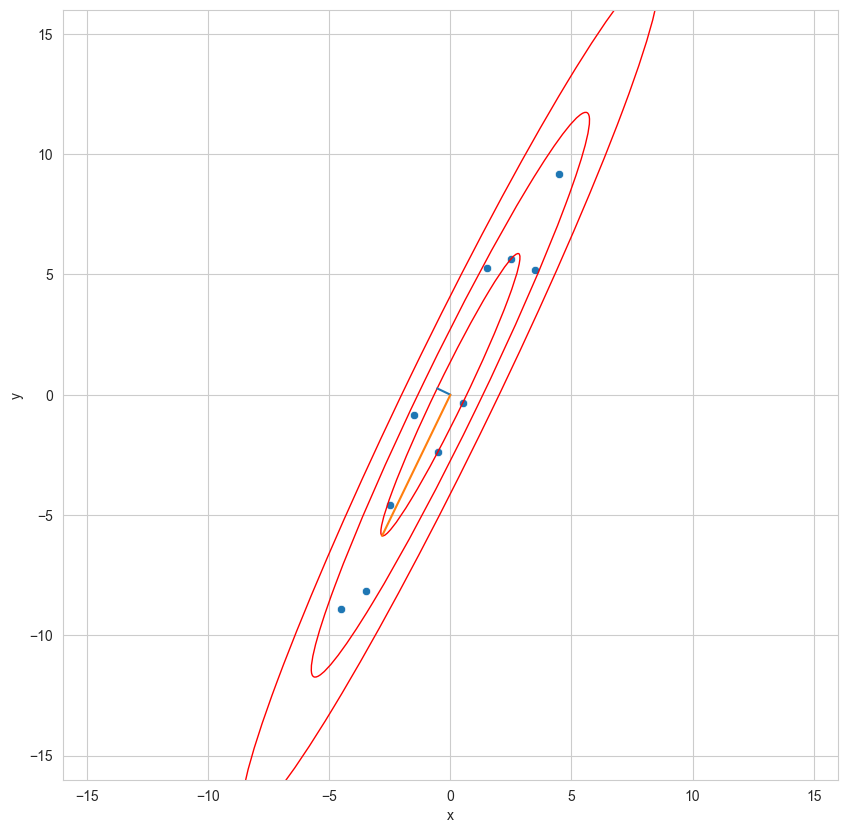

In [28]:
plt.figure(figsize=[10, 10])
plt.xlim([-16, 16])
plt.ylim([-16, 16])
ax = plt.gca()
sns.scatterplot(data=centered_data, x='x', y='y')

for i in range(2):
  sns.lineplot(x=[0, axes[0, i]], y = [0, axes[1, i]])
  
for k in range(1, 4):
  ax.add_patch(matplotlib.patches.Ellipse(
      (0, 0), 
      k * 2 * sigma[0],
      k * 2 * sigma[1], 
      angle=np.arctan(axes[1, 0] / axes[0, 0]) / np.pi * 180, 
      fill=False, color='red'))

plt.show()

Геометрически очевидно, что первая ГК должна идти вдоль оранжевого направления. Какой брать собственный вектор?

In [29]:
eigvalues

array([ 0.36663952, 42.30980373])

In [30]:
phi_1 = eigvectors[:, 1]
phi_1

array([-0.43353593, -0.90113628])

In [31]:
centered_projections = np.dot(centered_data, phi_1.T)
centered_projections

array([  9.97345218,   8.88204793,   5.2297382 ,   1.41632607,
         2.3474407 ,   0.11160261,  -5.39235642,  -6.16511954,
        -6.17168067, -10.23145105])

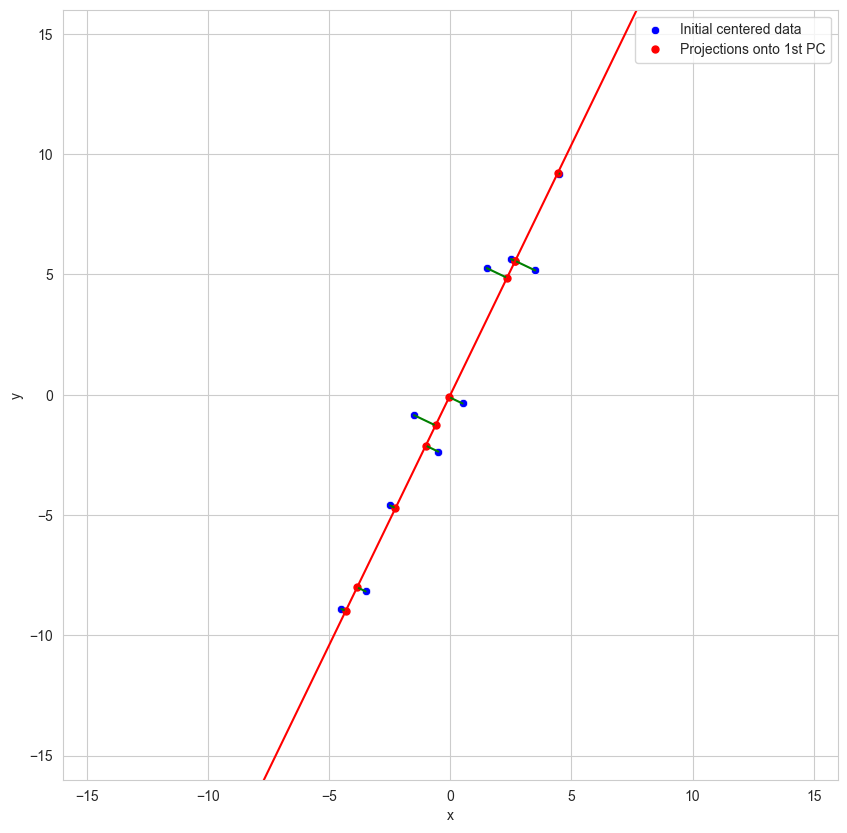

In [32]:
plt.figure(figsize=[10, 10])
plt.xlim([-16, 16])
plt.ylim([-16, 16])

recovered = np.dot(centered_projections.reshape(-1, 1), phi_1.reshape(1, -1))

sns.scatterplot(data = centered_data, x = 'x', y = 'y', color = 'blue')

plt.plot(recovered[:, 0], recovered[:, 1], '.', markersize=10, color='red')

plt.legend(['Initial centered data', 'Projections onto 1st PC'])

for i in range(len(data.values)):
  plt.plot([centered_data.values[i, 0], recovered[i, 0]], 
           [centered_data.values[i, 1], recovered[i, 1]], 
           '-', color='green')

plt.plot([phi_1[0] * -20, phi_1[0] * 20], [phi_1[1] * -20, phi_1[1] * 20], color='red')

plt.show()

In [16]:
from sklearn.decomposition import PCA

X = PCA(svd_solver='full', n_components=1).fit_transform(centered_data)
X

array([[ 9.67235779],
       [ 6.78534858],
       [ 8.30828911],
       [-0.75154288],
       [ 3.21773409],
       [-0.73759517],
       [-5.40298578],
       [-4.47955014],
       [-7.05366016],
       [-9.55839543]])

In [17]:
np.unique((np.round(X.reshape(1, -1),5) == np.round(centered_projections,5)))

array([ True])

# Пример применения PCA

Покажем применение PCA для визуализации и последующей возможности классификации (кластеризации) в известном наборе данных [iris (Ирисы Фишера)](https://ru.wikipedia.org/wiki/Ирисы_Фишера)

In [18]:
from sklearn.datasets import load_iris

In [19]:
iris_dataset = load_iris()
iris = pd.DataFrame(iris_dataset.data, columns = iris_dataset.feature_names)
iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [20]:
X_iris = PCA(svd_solver='full', n_components=2).fit_transform(iris)
X_iris.shape

(150, 2)

In [21]:
X_df = pd.DataFrame(X_iris, columns=['x', 'y'])
X_df['target'] = iris_dataset.target
X_df

,x,y,target
0,-2.684126,0.319397,0
1,-2.714142,-0.177001,0
2,-2.888991,-0.144949,0
3,-2.745343,-0.318299,0
4,-2.728717,0.326755,0
...,...,...,...
145,1.944110,0.187532,2
146,1.527167,-0.375317,2
147,1.764346,0.078859,2
148,1.900942,0.116628,2


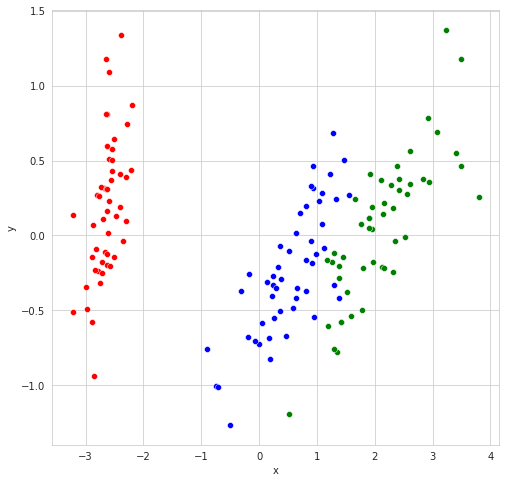

In [22]:
plt.figure(figsize=(8, 8))
for i in range(3):
  X_temp = X_df[X_df.target == i].drop('target', axis=1)
  sns.scatterplot(data=X_temp, x='x', y='y', color=['red', 'blue', 'green'][i])
plt.show()

Теперь обсудим детали. Матрица весов хранится в поле `components_` экземпляра класса `pca` и имеет размеры *(количество ГК, начальное количество признаков)*. Это значит, что матрица весов $\varPhi$, описанная в лекции, связана с матрицей весов `pca.components_`, выдаваемой инструментом, соотношением
$$
\varPhi = (\text{pca.components_})^T.
$$

In [23]:
pca = PCA(svd_solver='full', n_components=4).fit(iris)

Выведем полученные векторы весов (они в строках)

In [24]:
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143],
       [-0.31548719,  0.3197231 ,  0.47983899, -0.75365743]])

Можно посмотреть и на доли объясненной дисперсии, а также на кумулятивные суммы

In [25]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648, 0.01710261, 0.00521218])

In [26]:
np.cumsum(pca.explained_variance_ratio_)

array([0.92461872, 0.97768521, 0.99478782, 1.        ])

Теперь проведем преобразование ручками. Надо не забыть сдвинуть

In [27]:
iris_centered = iris - iris.mean()
iris_centered

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.743333,0.442667,-2.358,-0.999333
1,-0.943333,-0.057333,-2.358,-0.999333
2,-1.143333,0.142667,-2.458,-0.999333
3,-1.243333,0.042667,-2.258,-0.999333
4,-0.843333,0.542667,-2.358,-0.999333
...,...,...,...,...
145,0.856667,-0.057333,1.442,1.100667
146,0.456667,-0.557333,1.242,0.700667
147,0.656667,-0.057333,1.442,0.800667
148,0.356667,0.342667,1.642,1.100667


Снова будем использовать только первые две компоненты

In [28]:
iris_new = np.dot(iris_centered, pca.components_[0:2, :].T)

Результаты оказались приличными

In [29]:
np.unique(np.isclose(iris_new, X_df[['x', 'y']]))

array([ True])